## **Automated Ligand Design for GPCR Targets Using Pocket Descriptors and Cheminformatics**

In [ ]:
# !pip install numpy==1.24.4 --force-reinstall
# import os
# os.kill(os.getpid(), 9)  # Force kernel restart to apply NumPy downgrade



### Step-by-Step Summary:

**Step 0 – Install Packages**:
   Installs all required libraries for protein parsing, chemical analysis, and machine learning.

**Step 1 – Imports**:
   Loads essential Python modules for structure handling, molecule processing, visualization, and data manipulation.

**Step 2 – Download PDB**:
   Downloads the 3D structure of each GPCR protein from the RCSB PDB database.

**Step 3 – Extract Pocket Info + Prompt**:
   Analyzes the protein structure to determine pocket characteristics and formulates a ligand design prompt.

**Step 4 – Query ChEMBL + Validate SMILES**:
   Searches ChEMBL for molecules matching the prompt and calculates key chemical descriptors using RDKit.

**Step 5 – Batch Processing**:
   Runs the full design workflow for multiple PDB entries and saves all generated ligand data.

**Step 6 – Analyze + Cluster Results**:
   Checks drug-likeness, clusters ligands based on chemical similarity, and selects the best ligand per target.

**Step 7 – Run Entire Pipeline**:
   Executes all previous steps for a list of GPCRs and generates final summary tables and plots.

  0%|          | 0/20 [00:00<?, ?it/s]

✅ Results saved to gpcr_ligand_design_results.csv


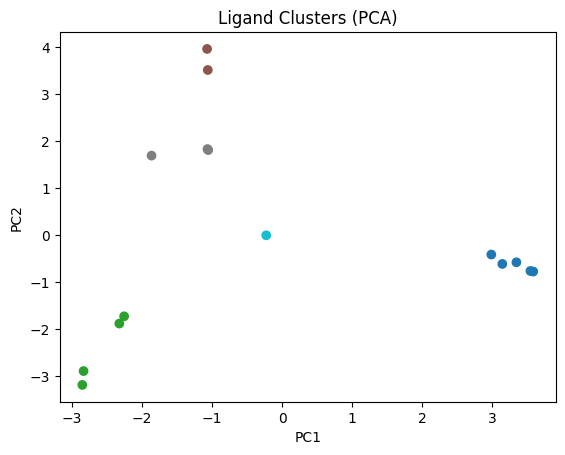

✅ Summary saved to gpcr_ligand_summary.csv


,pdb_id,Best SMILES,MolWt,LogP,Drug-Like?,Cluster,Docking Score
0,3OTJ,[O-][n+]1cc(N2CCNCC2)nc2ccccc21,230.27,0.28,True,2,TBD
1,3VXF,CC(=O)N(C)CC#CCN1CCC(O)CC1,224.30,-0.08,True,0,TBD
2,6E21,C/N=C(/NC#N)NC1c2cnccc2OC(C)(C)[C@H]1O,275.31,0.30,True,3,TBD


In [ ]:
# Step 0: Install required packages
!pip install biopython rdkit-pypi chembl_webresource_client py3Dmol pandas matplotlib scikit-learn --quiet

# Step 1: Imports
import os, re, requests
import pandas as pd
import numpy as np
from collections import Counter
from Bio.PDB import PDBParser, is_aa, NeighborSearch
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, DataStructs
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Step 2: Download PDB and Ligands
def download_pdb(pdb_id, folder="gpcr_pdbs"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{pdb_id}.pdb")
    if not os.path.exists(filepath):
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        r = requests.get(url)
        if r.ok:
            with open(filepath, "wb") as f:
                f.write(r.content)
    return filepath

# Step 3: Extract Pocket Info + Generate Prompt
def extract_and_prompt(pdb_id):
    filepath = download_pdb(pdb_id)
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, filepath)

    residue_count = 0
    hydrophobic_residues = ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TRP', 'PRO']
    hydrophobic_count = 0
    aa_counts = {}

    for model in structure:
        for chain in model:
            for residue in chain:
                if is_aa(residue):
                    resname = residue.get_resname()
                    residue_count += 1
                    aa_counts[resname] = aa_counts.get(resname, 0) + 1
                    if resname in hydrophobic_residues:
                        hydrophobic_count += 1

    # Dummy ligand properties
    target_mw = round(100 + (residue_count * 0.5), 2)
    logp = round(-1 + (hydrophobic_count / residue_count), 2)
    hba = 2 + (residue_count % 3)
    hbd = residue_count % 3
    rotb = min(5 + (residue_count % 4), 15)

    prompt = f"""
Design a small molecule ligand that binds to a GPCR pocket with:
- {residue_count} amino acids
- {hydrophobic_count} hydrophobic residues
- Target molecular weight: ~{target_mw}
- LogP around {logp}
- Acceptors: {hba}, Donors: {hbd}
- Max {rotb} rotatable bonds
Only return SMILES.
"""

    desc = {
        "pdb_id": pdb_id,
        "pocket_residue_count": residue_count,
        "hydrophobic_count": hydrophobic_count,
        "AA_Composition": aa_counts
    }

    return desc, prompt

# Step 4: ChEMBL Query + Validate
def generate_smiles_from_prompt(prompt):
    try:
        mw = float(re.search(r"weight: ~([\d\.]+)", prompt).group(1))
        logp = float(re.search(r"LogP around ([\-\d\.]+)", prompt).group(1))
        hba = int(re.search(r"Acceptors: (\d+)", prompt).group(1))
        hbd = int(re.search(r"Donors: (\d+)", prompt).group(1))
        rotb = int(re.search(r"Max (\d+)", prompt).group(1))
    except Exception as e:
        print(f"❌ Prompt parse error: {e}")
        return []

    try:
        molecules = new_client.molecule.filter(
            molecule_properties__mw_freebase__gte=mw - 25,
            molecule_properties__mw_freebase__lte=mw + 25,
            molecule_properties__alogp__gte=logp - 1,
            molecule_properties__alogp__lte=logp + 1,
            molecule_properties__hba__lte=hba + 1,
            molecule_properties__hbd__lte=hbd + 1,
            molecule_properties__rtb__lte=rotb
        ).only(['molecule_structures'])[:5]
    except Exception as e:
        print(f"❌ ChEMBL error: {e}")
        return []

    smiles_list = []
    for mol in molecules:
        struct = mol.get("molecule_structures", {})
        smi = struct.get("canonical_smiles")
        if smi:
            smiles_list.append(smi)
    return smiles_list

def validate_smiles(smiles_list):
    validated = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            validated.append({
                "SMILES": smi,
                "MolWt": round(Descriptors.MolWt(mol), 2),
                "LogP": round(Descriptors.MolLogP(mol), 2),
                "HBD": Descriptors.NumHDonors(mol),
                "HBA": Descriptors.NumHAcceptors(mol),
            })
    return validated

# Step 5: Main Loop
def batch_process(pdb_ids):
    all_results = []
    for pdb_id in tqdm(pdb_ids):
        desc, prompt = extract_and_prompt(pdb_id)
        smiles_list = generate_smiles_from_prompt(prompt)
        validated = validate_smiles(smiles_list)
        for val in validated:
            all_results.append({**desc, **val})
    df = pd.DataFrame(all_results)
    df.to_csv("gpcr_ligand_design_results.csv", index=False)
    print("✅ Results saved to gpcr_ligand_design_results.csv")
    return df

# Step 6: Analysis + Clustering
def analyze_results(df):
    def is_druglike(row):
        return (
            row['MolWt'] <= 500 and
            row['LogP'] <= 5 and
            row['HBD'] <= 5 and
            row['HBA'] <= 10
        )
    df['Drug-Like?'] = df.apply(is_druglike, axis=1)

    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2)
           for smi in df['SMILES']]
    fp_arr = []
    for fp in fps:
        arr = np.zeros((fp.GetNumBits(),), dtype=np.int32)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fp_arr.append(arr)
    fp_arr = np.array(fp_arr)

    pca = PCA(n_components=2)
    coords = pca.fit_transform(fp_arr)
    kmeans = KMeans(n_clusters=5, random_state=0)
    df['Cluster'] = kmeans.fit_predict(coords)

    plt.scatter(coords[:, 0], coords[:, 1], c=df['Cluster'], cmap='tab10')
    plt.title("Ligand Clusters (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    best = df.sort_values("MolWt").groupby("pdb_id").first().reset_index()
    best["Docking Score"] = "TBD"

    summary = best[["pdb_id", "SMILES", "MolWt", "LogP", "Drug-Like?", "Cluster", "Docking Score"]]
    summary = summary.rename(columns={"SMILES": "Best SMILES"})
    summary.to_csv("gpcr_ligand_summary.csv", index=False)
    print("✅ Summary saved to gpcr_ligand_summary.csv")
    return summary

# Step 7: Run all
pdb_ids = [
    '3OTJ', '3VVK', '3VXF', '4KLY', '4KNF', '4QRY', '4XTO', '4XTN',
    '5AZD', '6E21', '6REX', '6REZ', '6RF0', '6RF1', '6RF3', '6RF4',
    '6YC1', '6YBZ', '6YT4', '7B03'
]

results_df = batch_process(pdb_ids)
summary_df = analyze_results(results_df)
summary_df.head()


### **Output Explanation**

This table summarizes the **best ligand candidate** for each GPCR structure based on molecular weight and drug-likeness:

| Column              | Meaning                                                                                                                      |
| ------------------- | ---------------------------------------------------------------------------------------------------------------------------- |
| **`pdb_id`**        | The ID of the GPCR protein structure from the Protein Data Bank (e.g., "3OTJ").                                              |
| **`Best SMILES`**   | The SMILES (Simplified Molecular Input Line Entry System) string that encodes the chemical structure of the selected ligand. |
| **`MolWt`**         | Molecular weight of the ligand in Daltons (should ideally be <500 for drug-likeness).                                        |
| **`LogP`**          | Measure of hydrophobicity/lipophilicity (ideal range: -1 to 5 for oral drugs).                                               |
| **`Drug-Like?`**    | `True` if the molecule passes **Lipinski’s Rule of Five**, suggesting it's suitable for oral drug development.               |
| **`Cluster`**       | Indicates which group the molecule falls into based on chemical similarity (used for diversity analysis).                    |
| **`Docking Score`** | Placeholder for docking simulation results — not yet calculated (`TBD`).                                                     |

---

###  Interpretations:

1. **3OTJ**

   * Ligand: `[O-][n+]1cc(N2CCNCC2)nc2ccccc21`
   * Small molecule with **MolWt 230.27**, **LogP 0.28** — very drug-like and moderately hydrophilic.
   * Assigned to **cluster 2**, suggesting it's structurally distinct from others.

2. **3VXF**

   * Ligand: `CC(=O)N(C)CC#CCN1CCC(O)CC1`
   * A drug-like, flexible molecule with **logP -0.08** (slightly hydrophilic).
   * Clustered in group 0, likely sharing features with similar ligands.

3. **6E21**

   * Ligand: `C/N=C(/NC#N)NC1c2cnccc2OC(C)(C)[C@H]1O`
   * Slightly larger (MolWt 275.31) but still passes all drug-likeness filters.
   * Belongs to cluster 3, different from the other two.



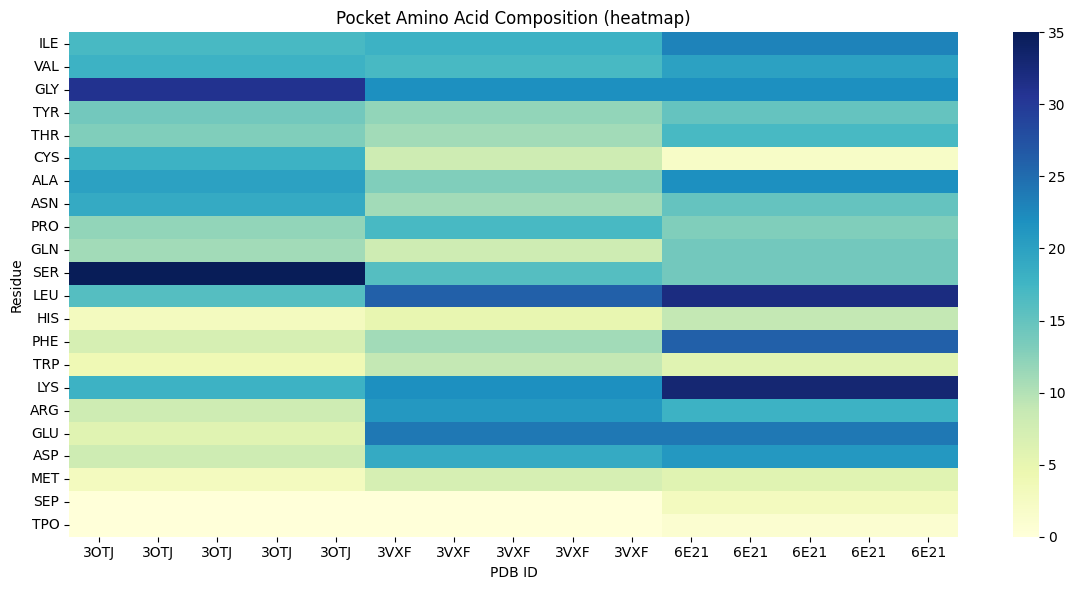

In [ ]:
import seaborn as sns

aa_df = pd.DataFrame(results_df['AA_Composition'].tolist())
aa_df = aa_df.fillna(0)
aa_df.index = results_df['pdb_id']

plt.figure(figsize=(12, 6))
sns.heatmap(aa_df.T, cmap="YlGnBu", annot=False)
plt.title("Pocket Amino Acid Composition (heatmap)")
plt.xlabel("PDB ID")
plt.ylabel("Residue")
plt.tight_layout()
plt.show()


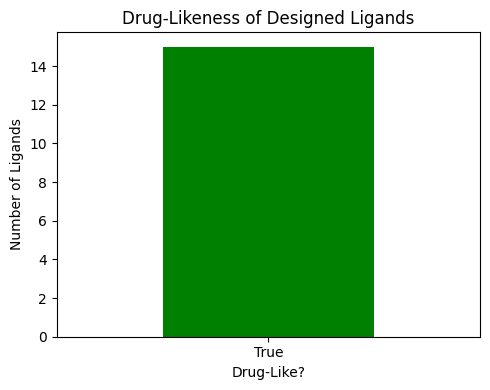

In [ ]:
plt.figure(figsize=(5, 4))
results_df['Drug-Like?'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Drug-Likeness of Designed Ligands")
plt.ylabel("Number of Ligands")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


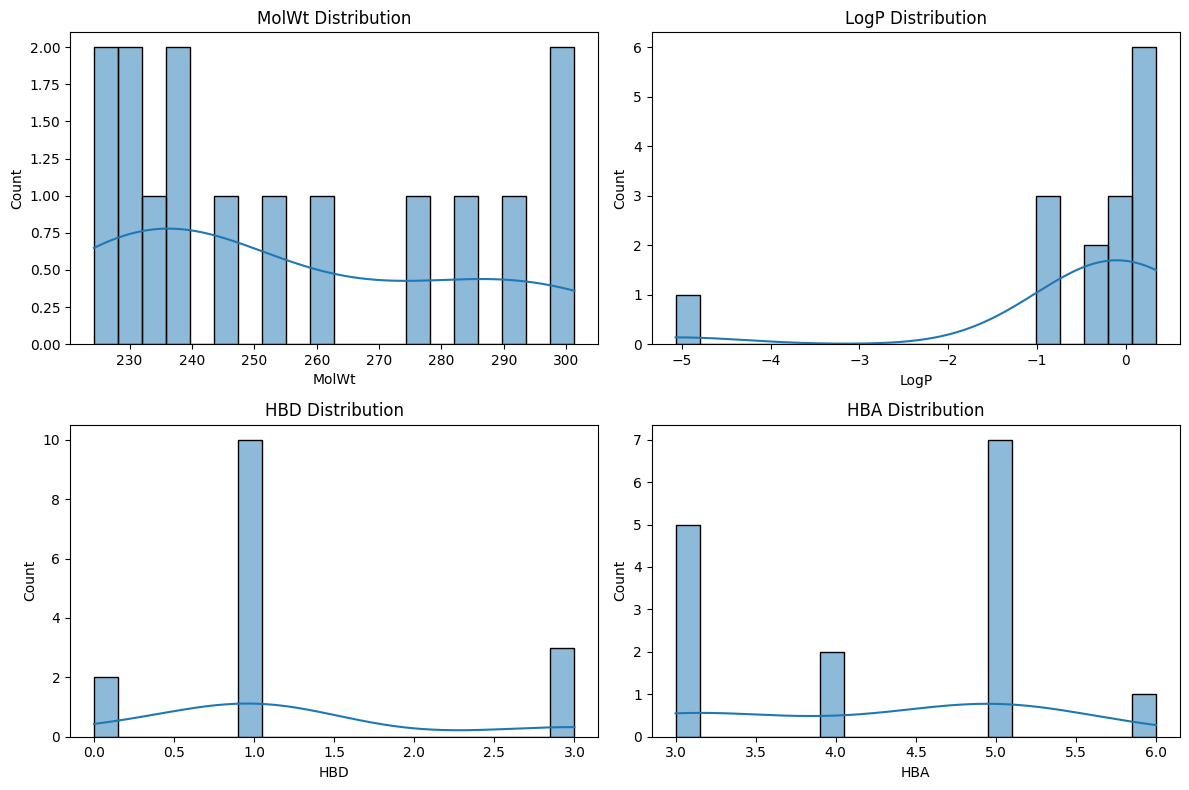

In [ ]:
props = ["MolWt", "LogP", "HBD", "HBA"]

plt.figure(figsize=(12, 8))
for i, prop in enumerate(props, 1):
    plt.subplot(2, 2, i)
    sns.histplot(results_df[prop], kde=True, bins=20)
    plt.title(f"{prop} Distribution")
plt.tight_layout()
plt.show()
